In [1]:
import sys, os
import json
import numpy as np
import matplotlib.pyplot as plt
import twinkle

#### INITIATE INTERACTIVE MATPLOTLIB PLOTTING

##### If this doesn't work, change to "%matplotlib inline" and update both matplotlib and jupyter notebook to make nbagg backend to work

In [2]:
%matplotlib nbagg

# 1. Setup JSON file
##### Change path to where you store your paramfile

In [3]:
jfile = os.path.join(os.path.expanduser('~'),'Dropbox','Research','sed_paramfile.json')

In [4]:
script = open(jfile).read()
specs = json.loads(script)

# 2.  Feed the json dictionary into twinkle with a starname

In [5]:
sname = 'Star_ID1'
tauA = twinkle.Star(jfile, starname=sname)

-------------------------------
      Loading All Gridmodels   
Loaded NextGen of g=40, met=0
       Done Loading Models     
-------------------------------
Bands used to fit photosphere: [u'BJ' u'VJ' u'J2M' u'H2M' u'Ks2M' u'W1' u'W2']
Bands used to scale photosphere: [u'BJ' u'VJ' u'J2M' u'H2M' u'Ks2M']


/Users/rpatel/Dropbox/Research/mosaic_tools.py:4032: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(rr) != 2:
/Users/rpatel/Dropbox/Research/sed.py:657: RuntimeWarning: divide by zero encountered in log10
  lam_arr_all, flux_arr_all = np.log10(lam_arr_all), np.log10(flux_arr_all)


chi2 = 5.78
Fitted Stellar Radius: 2.253 Rsun
Fitted Stellar Temperature: 8923 K


### AND THAT'S IT FOLKS! Your SED is lit!
### Now Let's do some more, shall we?

# 3. Plot Stellar SED

### You can either plot the data with the built in "plot_photosphere" and "plot_observedData" functions, or access the global data.

### Attributes of Instantiated Star object

In [68]:
dir(tauA)

['B_lim',
 'H_lim',
 'J_lim',
 'Ks_lim',
 'StarPhotosphere',
 'StarPhotosphere_unsc',
 'StarRadius',
 'StarTemp',
 'T0',
 'V_lim',
 'W1_lim',
 'W2Adopt',
 'W2_lim',
 'W3Adopt',
 'W3_lim',
 'W4_lim',
 '__doc__',
 '__init__',
 '__module__',
 'cleanphotometry',
 'disti',
 'emdat',
 'excessFlux',
 'fitPhotosphere',
 'flux',
 'fluxTup',
 'fluxerr',
 'fullspectrum',
 'g',
 'keep_unsatmags',
 'mags2use',
 'mags4Dust',
 'mags4Phot',
 'mags4scale',
 'met',
 'mfit',
 'modeli',
 'photFlux',
 'plot_observedData',
 'plot_photosphere',
 'sid',
 'spti',
 'starname',
 'starsdat',
 'su2ea',
 'su2ea_dust',
 'vegaMagDict',
 'vegaMagErrDict',
 'wave',
 'writeSED']

<IPython.core.display.Javascript object>


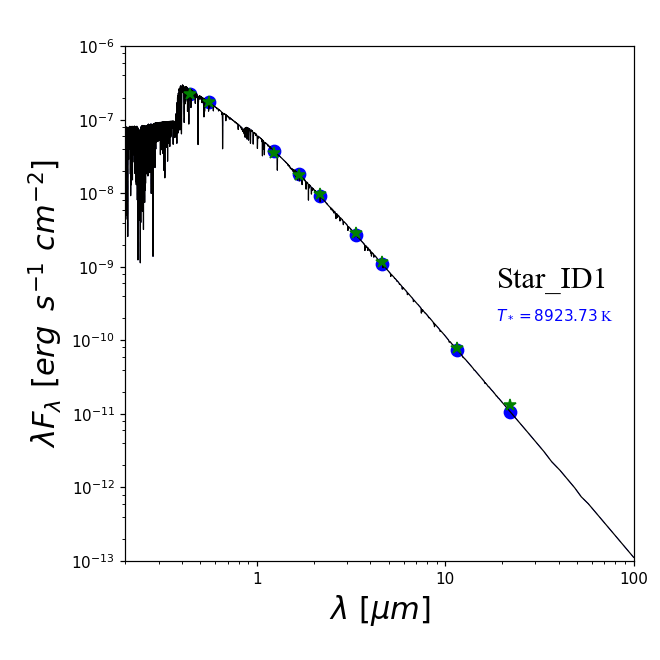

In [6]:
import matplotlib.ticker as mtick

# SET UP AXIS
ax = plt.figure(figsize=(6,6)).add_subplot(111)

# PLOT PHOTOSPHERIC AND LITERATURE DATA
tauA.plot_photosphere(ax, pointsize=8,lcolor='blue',pcolor='blue',lw=.5)
tauA.plot_observedData(ax, pointsize=8,lw=.8)

# ADDITIONAL PLOT STUFF
plt.loglog()
ax.set_xlim(.2,100)
ax.set_ylim(1e-13,1e-6)
ax.set_ylabel(r'$\lambda F_{\lambda}\ [erg\,\ s^{-1}\ cm^{-2}] $',fontsize=20, family='sans-serif')
ax.set_xlabel(r'$\lambda\ [\mu m]$', fontsize=20, family='sans-serif')
plt.subplots_adjust(left=.19, right=.96, bottom=.15, top=.93)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))


ax.annotate(r'{}'.format(tauA.starname), xy=(0.73, 0.53),xycoords='axes fraction',
            fontsize=20, family='Times New Roman')

ax.annotate(r'$T_* = {:.2f}$ K'.format(tauA.StarTemp), xy=(0.73, 0.47),
            xycoords='axes fraction',fontsize=10, family='Times New Roman', color='blue')

plt.show()

# 4. Add More To Star Object

## 4.1 Let's add some far infrared data to the Star Object (tauA)

In [7]:
# SED TOOLS
stoo = twinkle.STools

In [8]:
# OBTAIN ALL FAR-IR DATA FROM tauA.starsdat
magextra = ['HPACS100','HPACS160','Akari90']

HPACS160J, eHPACS160J = float(tauA.starsdat['fluxHPACS160']), float(tauA.starsdat['efluxHPACS160'])
HPACS100J, eHPACS100J = float(tauA.starsdat['fluxHPACS100']), float(tauA.starsdat['efluxHPACS100'])
Akari90J, eAkari90J = float(tauA.starsdat['fluxAkari90']), float(tauA.starsdat['efluxAkari90'])

#CONVERT Jy TO ERG/S/CM^2/ANGSTROM AND ADD TO DICTIONARY
for band in magextra:
    # OBTAIN ISOPHOTOAL FREQUENCY OF BANDPASS
    freq = eval('stoo.{}pband.isoFrequency()'.format(band))
    fj,efj = eval('{}J'.format(band)), eval('e{}J'.format(band))
    y, ey = np.array(stoo.Jy2cgs((freq,fj),(0,efj)))/ eval('stoo.%spband.isoWavelength()'%band)

    # ADD WAVELENGTHS AND FLUXES TO tauA RELEVANT DICTIONARIES
    tauA.wave[band] = eval('stoo.%spband.isoWavelength()'%band)
    tauA.flux[band+'_flux'] = y
    tauA.fluxerr[band+'_flux'] = ey
      
# GET PHOTOSPHERIC FLUXES     
for band in magextra:
    flxt = stoo.rsr_flux(getattr(stoo,'{}pband'.format(band)),*tauA.StarPhotosphere)[0]
    tauA.photFlux[band] = flxt

# 5. Calculate Excess IR Flux

In [9]:
# ADD FIR BAND STRINGS TO MAGS2USE
# ADD RELEVANT BANDS FOR EXCESS FITTING TO mags4Dust
print 'mag4Dust before adding FIR stuff:', tauA.mags4Dust
for band in magextra:
    tauA.mags2use.append(band)
    tauA.mags4Dust.append(band)

tauA.mags2use = list(np.unique(np.array(tauA.mags2use)))
tauA.mags4Dust = list(np.unique(np.array(tauA.mags4Dust)))
print 'mags2use', tauA.mags2use

# CREATE NEW tauA DICTIONARY FOR EXCESS FLUX
tauA.excessFlux = {}

# CALCULATE EXCESS FLUX AND ADD TO TAUA
for band in tauA.mags2use:
    exflux = tauA.flux[band + '_flux'] - tauA.photFlux[band]
    tauA.excessFlux[band+'_flux'] = exflux

fluxEx = np.array(zip(*sorted(tauA.excessFlux.items()))[1])
magsorder, waveEx = np.array(zip(*sorted(tauA.wave.items())))
waveEx = waveEx.astype('float64')
efluxEx = np.array(zip(*sorted(tauA.fluxerr.items()))[1])
print 'mags4Dust after adding FIR stuff:', tauA.mags4Dust

mag4Dust before adding FIR stuff: [u'W3', u'W4']
[u'Akari90', u'BJ', u'H2M', u'HPACS100', u'HPACS160', u'J2M', u'Ks2M', u'VJ', u'W1', u'W2', u'W3', u'W4']
mags4Dust after adding FIR stuff: [u'Akari90', u'HPACS100', u'HPACS160', u'W3', u'W4']


In [11]:
# COLLECT ONLY > 10 MICRON DATA
indfit = np.where(waveEx > 10 * twinkle._MICRON2ANG)[0]
waveEx_fit = waveEx[indfit]
fluxEx_fit = fluxEx[indfit] 
efluxEx_fit = efluxEx[indfit]
tauA.mags4Dust = magsorder[indfit]

## 5.1 Plot New SED With FAR - IR Data

<IPython.core.display.Javascript object>


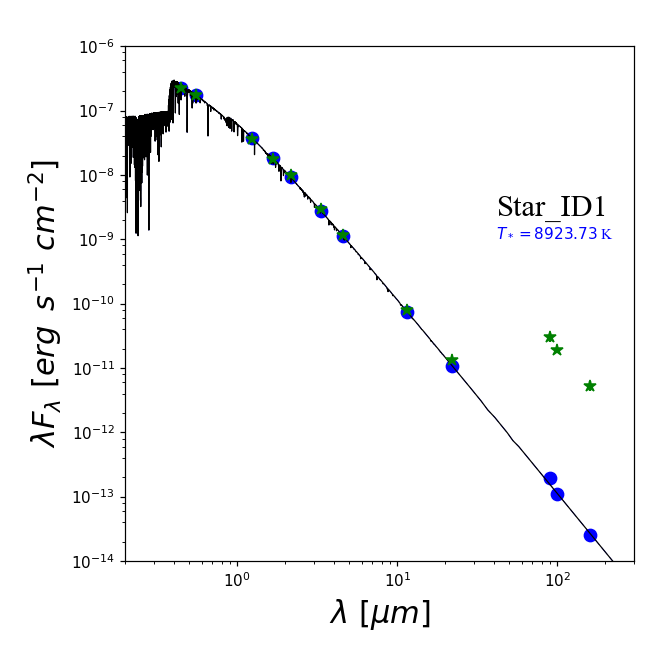

<IPython.core.display.Javascript object>


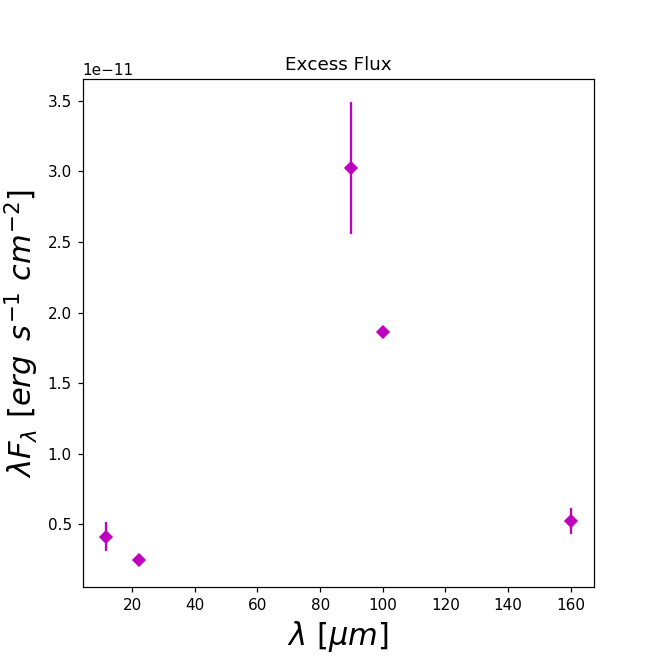

In [16]:
# SET UP AXIS
ax2 = plt.figure(figsize=(6,6)).add_subplot(111)
tauA.plot_photosphere(ax2, pointsize=8,lcolor='blue',pcolor='blue',lw=0.5)
tauA.plot_observedData(ax2,pointsize=8,lw=0.8)

ax2.set_xlim(.2,300)
ax2.set_ylim(1e-14,1e-6)
ax2.set_ylabel(r'$\lambda F_{\lambda}\ [erg\,\ s^{-1}\ cm^{-2}] $',fontsize=20, family='sans-serif')
ax2.set_xlabel(r'$\lambda\ [\mu m]$', fontsize=20, family='sans-serif')
plt.subplots_adjust(left=.19, right=.96, bottom=.15, top=.93)
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
ax2.annotate(r'{}'.format(tauA.starname), xy=(0.73, 0.67),xycoords='axes fraction',
            fontsize=20, family='Times New Roman')
ax2.annotate(r'$T_* = {:.2f}$ K'.format(tauA.StarTemp), xy=(0.73, 0.63),
            xycoords='axes fraction',fontsize=10, family='Times New Roman', color='blue')
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))

plt.loglog()
plt.show()

ax3 = plt.figure(figsize=(6,6)).add_subplot(111)
ax3.set_title('Excess Flux')
ax3.errorbar(waveEx_fit * twinkle._ANG2MICRON, waveEx_fit * fluxEx_fit,
             yerr=waveEx_fit * efluxEx_fit, fmt='mD',ms=6)
ax3.set_ylabel(r'$\lambda F_{\lambda}\ [erg\,\ s^{-1}\ cm^{-2}] $',fontsize=20, family='sans-serif')
ax3.set_xlabel(r'$\lambda\ [\mu m]$', fontsize=20, family='sans-serif')
ax3.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
plt.show()

# 6. FIT ONE TO TWO BLACKBODIES

## 6.1 Try fitting 1 blackbody first

In [17]:
# FOR NOW, USING OLD FITTING ROUTINES. WILL EVENTUALLY SWITCH TO PANDAS
# OR SCIPY
import mosaic_tools as mt
ft = mt.FittingTools()

# ==============================================
# INITIAL GUESS
tempdust = 150.
SEDx_ang = tauA.StarPhotosphere[0]
bbdust = {}
# ==============================================
# CALCULATE BROADBAND PHOTOMETRY ACROSS IR EXCESS WAVELENGTHS
for band in tauA.mags4Dust:
    bbdust[band] = stoo.blackbody(SEDx_ang,np.array([tempdust]),1, np.array([band]))[0]
bbdust_flux = np.array(zip(*sorted(bbdust.items()))[1]).flatten()

FluxNorm_dust = np.average(fluxEx_fit / bbdust_flux,
                           weights=1. / efluxEx_fit)
# INITIAL GUESS FOR DUST RADIUS
Rad_dust = np.sqrt(FluxNorm_dust / tauA.su2ea_dust)

# for band in tauA.mags4Dust[0:2]:
#     bbdust[band] = stoo.blackbody(tauA.StarPhotosphere[0],np.array([tempdust]),1, np.array([band]))[0]
# bbdust_flux = np.array(zip(*sorted(bbdust.items()))[1]).flatten()


# FluxNorm_dust = np.average(fluxEx_fit[-2:] / bbdust_flux,
#                            weights=1. / efluxEx_fit[-2:])
# Rad_dust = np.sqrt(FluxNorm_dust / tauA.su2ea_dust)



/Users/rpatel/Dropbox/Research/sed.py:787: RuntimeWarning: overflow encountered in exp
  fluxbb = const / (np.exp(_H * _CS / (x * _KB * temp0)) - 1)


In [18]:
# FIT BLACKBODY
p0_dust = np.array([tempdust, Rad_dust])
nparams = 2
fa_Dust = {'x': SEDx_ang, 'y': fluxEx_fit, 'err': efluxEx_fit,
           'func': stoo.blackbody, 'su2ea1': tauA.su2ea_dust, 'bands': tauA.mags4Dust,'bulk':True}
parinfo_dust = [{'value': 0., 'relstep': 0, 'limits': [0, 0], 'limited': [0, 0], 'fixed': 0} for m in
                range(nparams)]
for k in range(nparams): parinfo_dust[k]['value'] = p0_dust[k]
parinfo_dust[0]['relstep'] = 0.3
parinfo_dust[1]['relstep'] = 0.2
parinfo_dust[0]['limited'] = [1,1]
parinfo_dust[0]['limits'] = [10,500]

m_dust = mt.mpfit(ft.deviates_from_model, parinfo=parinfo_dust, functkw=fa_Dust)#,quiet=1)

# FIT BLACKBODY
# p0_dust = np.array([tempdust, Rad_dust])
# nparams = 2
# fa_Dust = {'x': tauA.StarPhotosphere[0], 'y': fluxEx_fit[-2:], 'err': efluxEx_fit[-2:],
#            'func': stoo.blackbody, 'su2ea1': tauA.su2ea_dust, 'bands': tauA.mags4Dust[0:2]}#,'bulk':True}
# parinfo_dust = [{'value': 0., 'relstep': 0, 'limits': [0, 0], 'limited': [0, 0], 'fixed': 0} for m in
#                 range(nparams)]
# for k in range(nparams): parinfo_dust[k]['value'] = p0_dust[k]
# parinfo_dust[0]['relstep'] = 0.3
# parinfo_dust[1]['relstep'] = 0.2
# parinfo_dust[0]['limited'] = [1,1]
# parinfo_dust[0]['limits'] = [100,500]

# m_dust = mt.mpfit(ft.deviates_from_model, parinfo=parinfo_dust, functkw=fa_Dust,quiet=1)



Iter       1    CHI-SQUARE =  219674.263  DOF =  3
   P0 = 150  
   P1 = 7.117300012  
Iter       2    CHI-SQUARE =  30691.36517  DOF =  3
   P0 = 143.2792534  
   P1 = 4.842093863  
Iter       3    CHI-SQUARE =  7338.932281  DOF =  3
   P0 = 122.9968855  
   P1 = 4.796496311  
Iter       4    CHI-SQUARE =  1647.902852  DOF =  3
   P0 = 89.14683157  
   P1 = 7.764192609  
Iter       5    CHI-SQUARE =  239.2054458  DOF =  3
   P0 = 73.20098189  
   P1 = 14.13555993  
Iter       6    CHI-SQUARE =  126.0749626  DOF =  3
   P0 = 70.30309863  
   P1 = 15.54930105  
Iter       7    CHI-SQUARE =  75.20199731  DOF =  3
   P0 = 68.35653759  
   P1 = 16.17792681  
Iter       8    CHI-SQUARE =  50.0370521  DOF =  3
   P0 = 66.89117051  
   P1 = 16.62837845  
Iter       9    CHI-SQUARE =  37.58634949  DOF =  3
   P0 = 65.77819364  
   P1 = 16.9812257  
Iter      10    CHI-SQUARE =  31.34980795  DOF =  3
   P0 = 64.93601108  
   P1 = 17.2578829  
Iter      11    CHI-SQUARE =  28.19507039  DOF =  3


### Print out Chi2 and dust temperatures

In [22]:
# CALCULATE SINGLE TEMP BLACKBODY FIT
p0_dust,errors = m_dust.params, m_dust.perror
chi2 = m_dust.fnorm/m_dust.dof
print 'Chi2={:.2f}, T={:.1f}, Radius = {:.1f}'.format(chi2,*p0_dust) # , p0_dust, errors 
dust_flux = stoo.blackbody(SEDx_ang, p0_dust,tauA.su2ea_dust)

Chi2=8.33, T=62.6, Radius = 18.1


## 6.2 Plot New SEDs With Fitted Blackbody

<IPython.core.display.Javascript object>


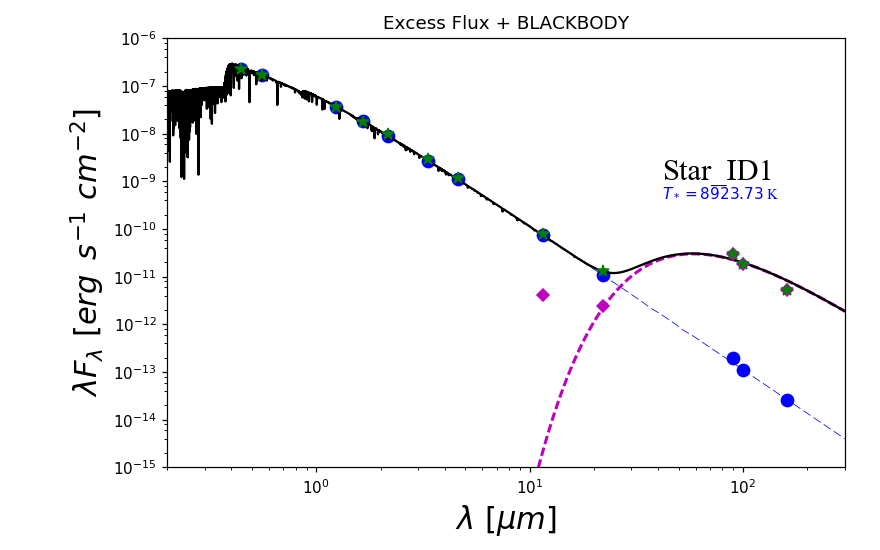

<IPython.core.display.Javascript object>


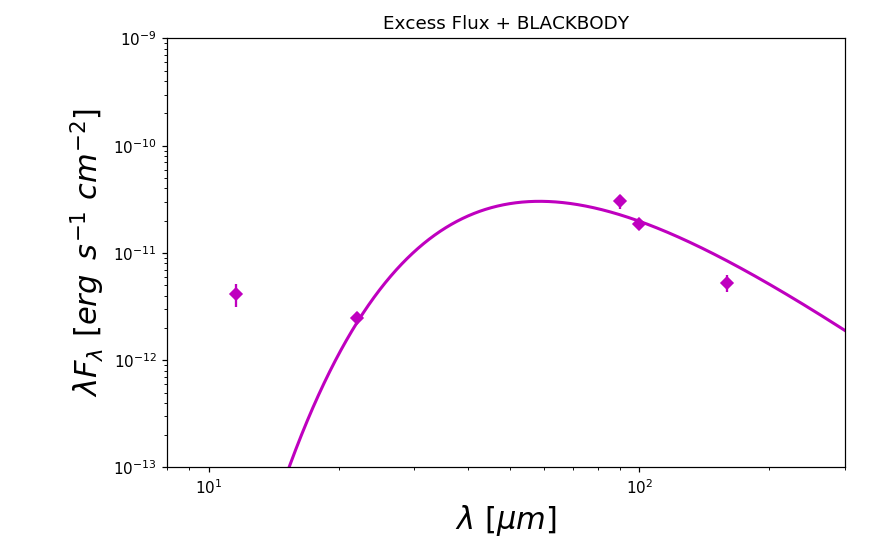

In [35]:
ax5 = plt.figure(figsize=(8,5)).add_subplot(111)
tauA.plot_photosphere(ax5, pointsize=8,lcolor='blue',pcolor='blue',lw=0.5)
tauA.fullspectrum = tauA.StarPhotosphere[1] + dust_flux
plt.plot(SEDx_ang * twinkle._ANG2MICRON, dust_flux * SEDx_ang, 'm-', ls='--',lw=2)
ax5.errorbar(waveEx_fit * twinkle._ANG2MICRON, waveEx_fit * fluxEx_fit, 
             yerr=waveEx_fit * efluxEx_fit, fmt='mD',ms=6)
tauA.plot_observedData(ax5,pointsize=8,lw=1.5)
ax5.set_title('Excess Flux + BLACKBODY')
ax5.set_xlim(.2,300)
ax5.set_ylim(1e-15,1e-6)
ax5.set_ylabel(r'$\lambda F_{\lambda}\ [erg\,\ s^{-1}\ cm^{-2}] $',fontsize=20, family='sans-serif')
ax5.set_xlabel(r'$\lambda\ [\mu m]$', fontsize=20, family='sans-serif')
plt.subplots_adjust(left=.19, right=.96, bottom=.15, top=.93)
ax5.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
ax5.annotate(r'{}'.format(tauA.starname), xy=(0.73, 0.67),xycoords='axes fraction',
            fontsize=20, family='Times New Roman')
ax5.annotate(r'$T_* = {:.2f}$ K'.format(tauA.StarTemp), xy=(0.73, 0.63),
            xycoords='axes fraction',fontsize=10, family='Times New Roman', color='blue')
ax5.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
plt.loglog()

# ===============================================================================================================
ax4 = plt.figure(figsize=(8,5)).add_subplot(111)
ax4.set_title('Excess Flux + BLACKBODY')
ax4.errorbar(waveEx_fit * twinkle._ANG2MICRON, waveEx_fit * fluxEx_fit,
             yerr=waveEx_fit * efluxEx_fit, fmt='mD',ms=6)
ax4.plot(SEDx_ang * twinkle._ANG2MICRON, dust_flux * SEDx_ang,'m-',lw=2)
ax4.set_ylabel(r'$\lambda F_{\lambda}\ [erg\,\ s^{-1}\ cm^{-2}] $',fontsize=20, family='sans-serif')
ax4.set_xlabel(r'$\lambda\ [\mu m]$', fontsize=20, family='sans-serif')
plt.subplots_adjust(left=.19, right=.96, bottom=.15, top=.93)
ax4.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
ax4.set_xlim(8,300)
ax4.set_ylim(1e-13,1e-9)

plt.loglog()
plt.show()